In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

In [8]:
df = pd.read_csv('data/nba_dataset.csv')

In [9]:
#OneHotEncode Positions and drop columns
df = pd.concat([df, pd.get_dummies(df['Pos'])],axis=1)

#Group my percentage ranges.
group = pd.cut(df['%_of_cap'],[0,0.1,0.15,0.2,0.25,df['%_of_cap'].max()], 
               labels=['0-10%','10%-15%','15%-20%','20%-25%','25%<='])
df['group']=group

df.drop(['Pos', '%_of_cap'], axis=1, inplace=True)

In [10]:
feature_names = ['Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'TRB%', 'AST%', 'STL%',
                 'BLK%', 'TOV%', 'USG%', 'WS', 'BPM', 'C', 'PF', 'PG', 'SF', 'SG']

X = np.array(df.iloc[:,0:20])
y = np.array(df.group)

In [11]:
df.head()

,Age,G,MP,PER,TS%,3PAr,FTr,TRB%,AST%,STL%,...,TOV%,USG%,WS,BPM,C,PF,PG,SF,SG,group
0,26,57,2029,18.6,0.535,0.324,0.164,3.9,34.7,1.6,...,10.1,25.1,5.5,1.1,0,0,1,0,0,10%-15%
1,31,53,516,9.6,0.489,0.055,0.133,10.6,9.2,0.9,...,13.4,17.7,0.2,-5.2,0,0,0,1,0,0-10%
2,22,60,560,8.7,0.506,0.426,0.161,4.2,31.6,2.5,...,29.1,18.8,0.2,-4.7,0,0,1,0,0,0-10%
3,23,41,362,7.8,0.447,0.314,0.343,4.1,20.8,3.0,...,22.0,19.0,-0.3,-6.1,0,0,0,0,1,0-10%
4,23,73,1614,11.8,0.518,0.008,0.289,10.8,6.5,1.8,...,11.9,13.7,1.7,-1.8,1,0,0,0,0,0-10%


In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

#Create dictionary of classifiers to try
classifiers = {'DecisionTree': DecisionTreeClassifier(random_state=34),  
               'RandomForest': RandomForestClassifier(random_state=34), 
               'SVC': SVC(random_state=34),   
               'AdaBoost': AdaBoostClassifier(random_state=34),
               'XGBoost': XGBClassifier(random_state=34)}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 34)


In [16]:
model_eval = pd.DataFrame({})
for key, classifier in classifiers.items():
    pipe = Pipeline(steps=[('minmax', MinMaxScaler()),
                           ('classifier', classifier)])
    kfold = KFold(n_splits=5, random_state=34)
    scores = cross_validate(pipe, X_train, y_train, cv=kfold) #Use cross_val_score to get the mean of each fold and standard deviation
    model_eval = model_eval.append({'classifier':key,    
                                    'mean_fit_time':scores['fit_time'].mean(),
                                    'mean_score_time':scores['score_time'].mean(),                       
                                    'mean_test_score':scores['test_score'].mean(),
                                    'std_test_score':scores['test_score'].std(),
                                    'mean_train_score':scores['train_score'].mean(),
                                    'std_train_score':scores['train_score'].mean()}, ignore_index=True)

/Users/brandon.arcilla/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/brandon.arcilla/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/brandon.arcilla/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/brandon.arcilla/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.2

In [17]:
model_eval[['classifier', 'mean_fit_time', 'mean_test_score', 
            'std_test_score', 'mean_train_score']]

,classifier,mean_fit_time,mean_test_score,std_test_score,mean_train_score
0,DecisionTree,0.093074,0.666398,0.007840,1.000000
1,RandomForest,0.164730,0.745540,0.009935,0.983501
2,SVC,1.325872,0.730651,0.011307,0.731388
3,AdaBoost,0.869530,0.747150,0.009784,0.758417
4,XGBoost,5.224224,0.758417,0.011314,0.793427


In [873]:
classifiers_opt = {'RandomForest': RandomForestClassifier(random_state=34),             
                   'AdaBoost': AdaBoostClassifier(random_state=34)}
model_eval2 = pd.DataFrame({})

for key, classifier in classifiers_opt.items():
    model_def = Pipeline(steps=[('minmax', MinMaxScaler()),                          
                                ('classifier', classifier)])
    model_def.fit(X_train, y_train)
    model_eval2 = model_eval2.append({'classifier':key,    
                                    'accuracy_score':model_def.score(X_test, y_test),
                                     'cm':confusion_matrix(y_test,model_def.predict(X_test)),
                                     'class_report': classification_report(y_test,model_def.predict(X_test),output_dict=True)}, ignore_index=True)

In [905]:
model_eval2[['classifier', 'accuracy_score']]

,classifier,accuracy_score
0,RandomForest,0.757344
1,AdaBoost,0.755332


In [903]:
#Unpacking Classification Report
metrics = pd.DataFrame({})

classification_report = model_eval2[['classifier',                                          
                                     'class_report']].set_index('classifier').to_dict()

for key_1, val_1 in classification_report.items():
    for key_2, val_2 in val_1.items():
        for key_3, val_3 in val_2.items():
            for key_4, val_4 in val_3.items():
                metrics = metrics.append({'classifier':key_2,                                  
                                          'group':key_3,                                  
                                         'metric':key_4, 
                                         'value':val_4},ignore_index=True)

#Create pivot table of classification table
classification_table = pd.pivot_table(metrics,                        
                                      values='value',                      
                                      index=['classifier', 'metric'],                      
                                     columns='group')

In [904]:
classification_table

group                         0-10%     10%-15%     15%-20%    20%-25%  \
classifier   metric                                                      
AdaBoost     f1-score      0.893530    0.182278    0.091837   0.105960   
             precision     0.833650    0.262774    0.360000   0.145455   
             recall        0.962678    0.139535    0.052632   0.083333   
             support    1822.000000  258.000000  171.000000  96.000000   
RandomForest f1-score      0.890909    0.188586    0.129870   0.165414   
             precision     0.825070    0.262069    0.250000   0.297297   
             recall        0.968167    0.147287    0.087719   0.114583   
             support    1822.000000  258.000000  171.000000  96.000000   

group                        25%<=    macro avg    micro avg  weighted avg  
classifier   metric                                                         
AdaBoost     f1-score     0.463576     0.347436     0.755332      0.710217  
             precision    0.426829     0.405742     0.755332      0.692609  
             recall       0.507246     0.349085     0.755332      0.755332  
             support    138.000000  2485.000000  2485.000000   2485.000000  
RandomForest f1-score     0.444444     0.363845     0.757344      0.712802  
             precision    0.514286     0.429744     0.757344      0.689398  
             recall       0.391304     0.341812     0.757344      0.757344  
             support    138.000000  2485.000000  2485.000000   2485.000000

Hyperparameter Tuning

Will begin with using GridSearch for AdaBoost Classifier

In [887]:
param_grid_ada = {'learning_rate':[.001, .01, .1],                                
                  'n_estimators':[500, 1000, 2000],                                                   
                  'random_state':[34]}

kfold = KFold(n_splits=5, random_state=34)
grid = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid_ada ,cv=kfold)

pipe_ada = Pipeline(steps = [('minmax', MinMaxScaler()),
                            ('grid', grid)])
pipe_ada.fit(X_train, y_train)

#grid = grid.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('grid', GridSearchCV(cv=KFold(n_splits=5, random_state=34, shuffle=False),
       error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimator...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [893]:
ada_predict = pipe_ada.predict(X_test)
print('Model Accuracy: ', accuracy_score(y_test, ada_predict))
print('Training Score: ' , pipe_ada.score(X_train, y_train))
print('Best Parameters: ', pipe_ada.steps[1][1].best_params_)

Model Accuracy:  0.7637826961770624
Training Score:  0.7691482226693495
Best Parameters:  {'learning_rate': 0.1, 'n_estimators': 1000, 'random_state': 34}


In [895]:
print(confusion_matrix(y_test, ada_predict))

[[1762   33    2   11   14]
 [ 192   39    8    4   15]
 [  84   38   11   10   28]
 [  36   15    9   14   22]
 [  18   23    6   19   72]]


In [894]:
print(classification_report(y_test, ada_predict))

              precision    recall  f1-score   support

       0-10%       0.84      0.97      0.90      1822
     10%-15%       0.26      0.15      0.19       258
     15%-20%       0.31      0.06      0.11       171
     20%-25%       0.24      0.15      0.18        96
       25%<=       0.48      0.52      0.50       138

   micro avg       0.76      0.76      0.76      2485
   macro avg       0.43      0.37      0.38      2485
weighted avg       0.70      0.76      0.72      2485



In [18]:
param_grid_ada = {'learning_rate':[.1],                                
                  'n_estimators':[1000],                                                   
                  'random_state':[34]}

kfold = KFold(n_splits=5, random_state=34)
grid = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid_ada ,cv=kfold)

pipe_ada = Pipeline(steps = [('minmax', MinMaxScaler()),
                            ('grid', grid)])
pipe_ada.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('grid', GridSearchCV(cv=KFold(n_splits=5, random_state=34, shuffle=False),
       error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimator...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [19]:
for feature, importance in zip(feature_names, pipe_ada.steps[1][1].best_estimator_.feature_importances_):
    print (feature, '=', importance)

Age = 0.117
G = 0.139
MP = 0.162
PER = 0.039
TS% = 0.078
3PAr = 0.015
FTr = 0.054
TRB% = 0.078
AST% = 0.038
STL% = 0.039
BLK% = 0.036
TOV% = 0.05
USG% = 0.066
WS = 0.02
BPM = 0.067
C = 0.0
PF = 0.002
PG = 0.0
SF = 0.0
SG = 0.0


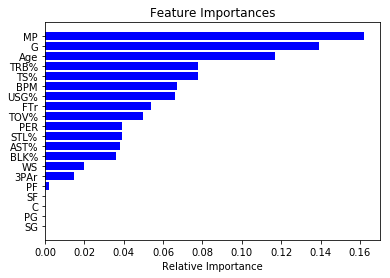

In [21]:
features = feature_names
importances = pipe_ada.steps[1][1].best_estimator_.feature_importances_
indices = np.argsort(importances)

_ = plt.title('Feature Importances')
_ = plt.barh(range(len(indices)), importances[indices], color='b', align='center')
_ = plt.yticks(range(len(indices)), [features[i] for i in indices])
_ = plt.xlabel('Relative Importance')
plt.show()

In [898]:
param_grid_rf = {'max_features':['auto', 'sqrt', 'log2'],                                  
                 'n_estimators':[500, 1000, 2000],  
                 'max_depth':[2, 3, 5, 8],
                 'random_state':[34]}

kfold = KFold(n_splits=5, random_state=34)
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf ,cv=kfold)

pipe_rf = Pipeline(steps = [('minmax', MinMaxScaler()),
                            ('grid_rf', grid_rf)])
pipe_rf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('grid_rf', GridSearchCV(cv=KFold(n_splits=5, random_state=34, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [899]:
rf_predict = pipe_rf.predict(X_test)

print('Model Accuracy: ', accuracy_score(y_test, rf_predict))
print('Training Score: ' , pipe_rf.score(X_train, y_train))
print('Best Parameters: ', pipe_rf.steps[1][1].best_params_)

Model Accuracy:  0.7625754527162978
Training Score:  0.794634473507713
Best Parameters:  {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 2000, 'random_state': 34}


In [859]:
print(confusion_matrix(y_test, rf_predict))

[[1803    6    1    1   11]
 [ 226   16    5    0   11]
 [ 126   10    4    1   30]
 [  63    5    0    0   28]
 [  50   10    5    1   72]]


In [858]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

       0-10%       0.79      0.99      0.88      1822
     10%-15%       0.34      0.06      0.10       258
     15%-20%       0.27      0.02      0.04       171
     20%-25%       0.00      0.00      0.00        96
       25%<=       0.47      0.52      0.50       138

   micro avg       0.76      0.76      0.76      2485
   macro avg       0.38      0.32      0.31      2485
weighted avg       0.66      0.76      0.69      2485

